Load data

In [1]:
import rosbag
import sensor_msgs.point_cloud2

import numpy as np

# livox mid360 lidar undistorted using fast-lio
bag_name = "/home/harry7557558/2024-06-08-16-51-41.bag"

bag = rosbag.Bag(bag_name)

all_clouds = []
for topic, msg, msg_t in bag.read_messages():
    if topic != "/cloud_train_undistorted":
        continue
    points = sensor_msgs.point_cloud2.read_points(
            msg, field_names=("x", "y", "z", "curvature"),
            skip_nans=True)
    points = np.array([*points])
    positions = points[:, :3]
    times = points[:, 3] / 1000
    all_clouds.append((positions, times))

print(len(all_clouds), 'clouds')

106 clouds


Apply fake distortion

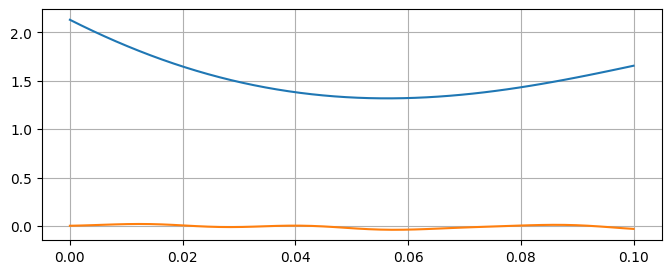

In [2]:
def random_signal(ts, n, amp, freq, decay):
    dt = np.amax(ts)-np.amin(ts)
    w = freq * 2.0*np.pi/dt
    I = np.arange(n)
    A = amp * np.random.randn(n) * np.exp(-decay*I)
    T = 2.0*np.pi*np.random.random(n)
    ws = np.sum(A[:,None]*np.sin(w*np.outer(I,ts)+T[:,None]), axis=0)
    return ws

# https://www.desmos.com/calculator/e5ghr5v301
RAND_VEL = (15, 3.0, 0.05, 0.2)
RAND_TWIST = (15, 3.0, 0.05, 0.2)
RAND_POS_D = (7, 0.05, 0.65, 0.3)
RAND_POSE_D = (7, 0.05, 0.65, 0.3)

ts = np.linspace(0, 0.1)
ws1 = random_signal(ts, *RAND_VEL)
ws2 = random_signal(ts, *RAND_POS_D)

import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(8,3))
plt.plot(ts, ws1)
plt.plot(ts, ws2)
plt.grid()
plt.show()

In [3]:
def exp_so3(phi):
    theta = np.linalg.norm(phi, axis=1).reshape((-1,1))
    theta = np.fmax(theta, 1e-12*np.ones_like(theta))
    n = phi / theta
    nnT = np.einsum('ki,kj->kij', n, n)
    n_star = np.zeros_like(nnT)
    n_star[:,0,1] = -n[:,2]
    n_star[:,0,2] = n[:,1]
    n_star[:,1,0] = n[:,2]
    n_star[:,1,2] = -n[:,0]
    n_star[:,2,0] = -n[:,1]
    n_star[:,2,1] = n[:,0]
    I = np.eye(3).reshape((-1,3,3)).repeat(len(theta),axis=0)
    theta = theta.reshape((-1,1,1))
    R = np.cos(theta) * I + \
        (1.0-np.cos(theta)) * nnT + \
        np.sin(theta) * n_star
    if True:
        residual = np.einsum('nij,nkj->nik', R, R) - I
        assert (np.linalg.norm(residual, axis=(1,2)) < 1e-12).all()
    return R

def apply_distortion(points, times):
    times = times - np.amax(times)  # odometry starts at the end
    delta_t = np.random.rand(len(times)) * np.median(times[1:]-times[:-1])
    # print(delta_t)
    # plt.hist(times[1:]-times[:-1], bins=1000)
    # plt.xlim(0.0, 2e-5)
    # plt.show()

    # noise = 0.05 * np.random.randn(*points.shape)
    # return points + noise

    # apply noise
    vel = np.array([random_signal(times, *RAND_VEL) for _ in range(3)]).T
    so3 = np.array([random_signal(times, *RAND_TWIST) for _ in range(3)]).T
    vel_p = vel + np.cross(so3, points)
    points = points - vel_p * delta_t[:,None]
    
    # apply bias distortion
    pos_d = np.array([random_signal(times, *RAND_POS_D) for _ in range(3)]).T
    so3_d = np.array([random_signal(times, *RAND_POSE_D) for _ in range(3)]).T
    points = np.einsum('kij,kj->ki', exp_so3(so3_d), points) + pos_d

    return points


pcl1, times1 = all_clouds[4]
pcl2 = apply_distortion(pcl1, times1)

%matplotlib tk
# %matplotlib inline

fig = plt.figure(figsize=(14, 14))
ax1 = fig.add_subplot(111, projection='3d')
ax1.scatter(pcl1[:,0], pcl1[:,1], pcl1[:,2], s=1)
ax1.scatter(pcl2[:,0], pcl2[:,1], pcl2[:,2], s=1)
plt.show()

Normalize point clouds

In [4]:
all_clouds_normalized = []
for points, times in all_clouds:
    norms = np.linalg.norm(points, axis=1)
    mean_norm = np.mean(norms)
    normalized = points / mean_norm
    distorted = apply_distortion(points, times)
    distorted_normalized = distorted / mean_norm
    all_clouds_normalized.append((normalized, distorted_normalized, times, mean_norm))

Create data

In [5]:
from scipy.spatial import KDTree
from torch_geometric.data import Data, DataLoader
import torch

NUM_NEIGHBORS = 5

all_data = []

for cloud_gt, cloud, times, mean_norm in all_clouds_normalized:
    times_normalized = (times-np.amin(times)) / (np.amax(times)-np.amin(times))
    tree = KDTree(cloud)
    data_x = []
    data_y = []
    edge_index = set()
    for i1, (point_gt, point, time) in enumerate(zip(cloud_gt, cloud, times_normalized)):
        # decomposed point
        point_norm = np.linalg.norm(point)
        point_dir = point / point_norm
        # time embedding
        time_embeddings = [time]
        for i in range(1, 4):
            time_embeddings += [np.cos(2*np.pi*i*time), np.sin(2*np.pi*i*time)]
        # x data - concatenate
        data_x.append(np.concatenate((
            point, [point_norm], point_dir,
            time_embeddings)))
        # y data - residual
        data_y.append(point_gt-point)
        # indices
        distances, indices = tree.query(point, NUM_NEIGHBORS+1)
        for i2 in indices[1:]:
            edge_index.add((i1, i2))
            edge_index.add((i2, i1))
    # pack data
    data_x = torch.from_numpy(np.array(data_x)).float().contiguous()
    data_y = torch.from_numpy(np.array(data_y)).float().contiguous()
    edge_index = list(edge_index)
    edge_index = torch.from_numpy(np.array(edge_index)).contiguous()
    data = Data(x=data_x, y=data_y, edge_index=edge_index.T)
    all_data.append(data)
    if len(all_data) % 10 == 0:
        print(len(all_data), '/', len(all_clouds_normalized))

import random
random.seed(42)
random.shuffle(all_data)

10 / 106
20 / 106
30 / 106
40 / 106
50 / 106
60 / 106
70 / 106
80 / 106
90 / 106
100 / 106


Define model

In [6]:
import torch.nn.functional as F
from torch_geometric.nn import GATConv


class Model(torch.nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels=64, num_layers=4, heads=4, mode='cat'):
        super(Model, self).__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(GATConv(in_channels, hidden_channels, heads=heads))
        for _ in range(num_layers - 2):
            self.convs.append(GATConv(hidden_channels * heads, hidden_channels, heads=heads))
        self.convs.append(GATConv(hidden_channels * heads, out_channels, heads=1))

        self.mode = mode
        if self.mode == 'cat':
            self.jk = lambda xs: torch.cat(xs, dim=-1)
        elif self.mode == 'max':
            self.jk = lambda xs: torch.stack(xs, dim=-1).max(dim=-1)[0]
        elif self.mode == 'lstm':
            self.lstm = torch.nn.LSTM(hidden_channels * heads, hidden_channels * heads, batch_first=True)
            self.jk = lambda xs: self.lstm(torch.stack(xs, dim=1))[0][:, -1, :]

        jk_channels = hidden_channels * heads * (num_layers - 1) if mode == 'cat' else hidden_channels * heads
        self.final_linear = torch.nn.Linear(jk_channels, out_channels)

    def forward(self, x, edge_index):
        xs = []
        for conv in self.convs[:-1]:
            x = F.elu(conv(x, edge_index))
            xs.append(x)
        x = self.jk(xs)
        x = self.final_linear(x)
        return x

data = all_data[0]
in_channels = data.x.shape[1]
out_channels = data.y.shape[1]

model = Model(in_channels, out_channels,
              hidden_channels=64, num_layers=12, heads=4, mode='cat')
print(model)
print(data.y.shape)
data_y = model(data.x, data.edge_index)
print(data_y.shape)
print(data_y.mean().item(), data_y.std().item())

Model(
  (convs): ModuleList(
    (0): GATConv(14, 64, heads=4)
    (1-10): 10 x GATConv(256, 64, heads=4)
    (11): GATConv(256, 3, heads=1)
  )
  (final_linear): Linear(in_features=2816, out_features=3, bias=True)
)
torch.Size([5825, 3])
torch.Size([5825, 3])
0.0025537924375385046 0.08534074574708939


Train model

In [7]:
train_loader = DataLoader(all_data[:int(0.8 * len(all_data))], batch_size=4, shuffle=True)
val_loader = DataLoader(all_data[int(0.8 * len(all_data)):], batch_size=1, shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
print(device)

model = Model(in_channels, out_channels).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.L1Loss().to(device)


/home/harry7557558/.local/lib/python3.8/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


cuda


start, val 0.0929
epoch 5, train 0.0395, val 0.0400
epoch 10, train 0.0380, val 0.0379
epoch 15, train 0.0364, val 0.0380
epoch 20, train 0.0360, val 0.0388
epoch 25, train 0.0363, val 0.0387
epoch 30, train 0.0362, val 0.0361
epoch 35, train 0.0362, val 0.0367
epoch 40, train 0.0363, val 0.0368
epoch 45, train 0.0359, val 0.0366
epoch 50, train 0.0363, val 0.0364
epoch 55, train 0.0361, val 0.0368
epoch 60, train 0.0354, val 0.0374
epoch 65, train 0.0356, val 0.0369
epoch 70, train 0.0359, val 0.0377
epoch 75, train 0.0357, val 0.0374
epoch 80, train 0.0360, val 0.0369
epoch 85, train 0.0351, val 0.0374
epoch 90, train 0.0355, val 0.0364
epoch 95, train 0.0357, val 0.0370
epoch 100, train 0.0353, val 0.0368


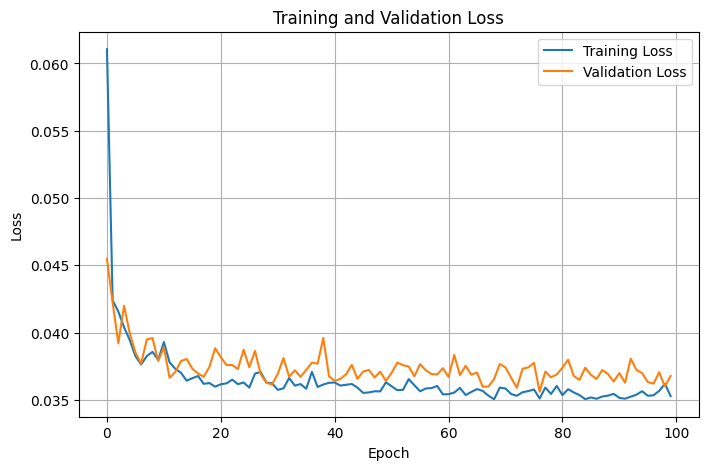

In [8]:
def train(loader):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def test(loader):
    model.eval()
    loss = 0
    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            out = model(data.x, data.edge_index)
            loss += criterion(out, data.y).item()
    return loss / len(loader)

val_loss = test(val_loader)
print(f"start, val {val_loss:.4f}")

train_losses = []
val_losses = []

num_epochs = 100
for epoch in range(num_epochs):
    train_loss = train(train_loader)
    val_loss = test(val_loader)
    if (epoch+1) % 5 == 0:
        print(f'epoch {epoch+1}, train {train_loss:.4f}, val {val_loss:.4f}')
    train_losses.append(train_loss)
    val_losses.append(val_loss)

%matplotlib inline
plt.figure(figsize=(8, 5))
plt.plot(range(num_epochs), train_losses, label='Training Loss')
plt.plot(range(num_epochs), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

Evaluate model

In [9]:
def undistort_cloud(cloud, times):
    times_normalized = (times-np.amin(times)) / (np.amax(times)-np.amin(times))
    tree = KDTree(cloud)
    data_x = []
    edge_index = set()
    for i1, (point, time) in enumerate(zip(cloud, times_normalized)):
        # decomposed point
        point_norm = np.linalg.norm(point)
        point_dir = point / point_norm
        # time embedding
        time_embeddings = [time]
        for i in range(1, 4):
            time_embeddings += [np.cos(2*np.pi*i*time), np.sin(2*np.pi*i*time)]
        # x data - concatenate
        data_x.append(np.concatenate((
            point, [point_norm], point_dir,
            time_embeddings)))
        # indices
        distances, indices = tree.query(point, NUM_NEIGHBORS+1)
        for i2 in indices[1:]:
            edge_index.add((i1, i2))
            edge_index.add((i2, i1))
    # pack data
    data_x = torch.from_numpy(np.array(data_x)).float().contiguous()
    edge_index = list(edge_index)
    edge_index = torch.from_numpy(np.array(edge_index)).contiguous()

    # inference model
    with torch.no_grad():
        out = model(data_x.to(device), edge_index.T.to(device))
    out = out.cpu().numpy()
    print(out.mean(), out.std())
    return cloud + out


pcl1, times1 = all_clouds[4]
pcl2 = apply_distortion(pcl1, times1)

norms = np.linalg.norm(pcl2, axis=1)
mean_norm = np.mean(norms)
pcl1_normalized = pcl1 / mean_norm
pcl2_normalized = pcl2 / mean_norm

print(mean_norm)
pcl3_normalized = undistort_cloud(pcl2_normalized, times1)
pcl3 = pcl3_normalized * mean_norm

print((pcl3-pcl2).std()/mean_norm)
print((pcl3-pcl1).std()/mean_norm)
print((pcl2-pcl1).std()/mean_norm)

%matplotlib tk

fig = plt.figure(figsize=(16, 10))
ax1 = fig.add_subplot(121, projection='3d', proj_type='ortho')
ax2 = fig.add_subplot(122, projection='3d', proj_type='ortho')
ax1.scatter(pcl1[:,0], pcl1[:,1], pcl1[:,2], s=0.2)
ax1.scatter(pcl2[:,0], pcl2[:,1], pcl2[:,2], s=0.2)
ax2.scatter(pcl1[:,0], pcl1[:,1], pcl1[:,2], s=0.2)
ax2.scatter(pcl3[:,0], pcl3[:,1], pcl3[:,2], s=0.2)
plt.show()

3.130031062963576
0.002017798 0.011363907
0.011363905973642067
0.0467543470029019
0.04971567082829518
